In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer
import seaborn as sns

In [97]:
print(tf.__version__)

2.4.1


# regression

In [2]:
#prepare data for regression

data = pd.read_csv('year_prediction.csv')
data = data.sample(frac=1)
data = data[data['label']>1940]
data.reset_index(inplace=True, drop=True)

X = data.iloc[:,1:]
Y = data.iloc[:,0]


# Train set
X_train = X.iloc[0:463810,:]
y_train = Y.iloc[0:463810]

# Test set
X_test = X.iloc[463810:,:]
y_test = Y.iloc[463810:]

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [3]:
def get_network():
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(128, input_shape=(90,), activation="relu"))
    model.add(keras.layers.Dense(128, activation="relu"))
    model.add(keras.layers.Dense(1))
    opt = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(loss= "mse", optimizer= opt, metrics=["mae"])
    return model

In [4]:
class EarlyStoppingCallback(keras.callbacks.Callback):
    
    def __init__(self,patience = 0):
        super(EarlyStoppingCallback,self).__init__()
        self.patience = patience
        
    def on_train_begin(self, logs=None):
        self.best = np.inf
        self.wait = 0
        self.stopped_epoch = 0
        
    def on_epoch_end(self,epoch,logs=None):
        current_loss = logs.get('val_loss')
        if np.less(current_loss,self.best):
            self.best = current_loss
            self.wait = 0
            self.best_weights = self.model.get_weights()
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                self.model.set_weights(self.best_weights)
    
    def on_train_end(self,logs=None):
        if self.stopped_epoch > 0:
            print('epoch: %d early stopping'% self.stopped_epoch)
                
        

In [5]:
model = get_network()
model = keras.wrappers.scikit_learn.KerasRegressor(build_fn=get_network, epochs=50, batch_size=64)
EarlyStoppingCallback = EarlyStoppingCallback(patience=5)
model.fit(X_train,y_train,validation_split = 0.22,callbacks=[EarlyStoppingCallback])

Epoch 1/50
5653/5653 [==============================] - 9s 1ms/step - loss: 556762.1131 - mae: 461.7849 - val_loss: 1508.6749 - val_mae: 25.0797
Epoch 2/50
5653/5653 [==============================] - 6s 1ms/step - loss: 466.8959 - mae: 13.5983 - val_loss: 182.7217 - val_mae: 8.7744
Epoch 3/50
5653/5653 [==============================] - 6s 1ms/step - loss: 213.7516 - mae: 9.9985 - val_loss: 400.3651 - val_mae: 13.9189
Epoch 4/50
5653/5653 [==============================] - 6s 1ms/step - loss: 198.6553 - mae: 9.7320 - val_loss: 179.7894 - val_mae: 9.2243
Epoch 5/50
5653/5653 [==============================] - 6s 1ms/step - loss: 222.4614 - mae: 9.8148 - val_loss: 216.0213 - val_mae: 10.6769
Epoch 6/50
5653/5653 [==============================] - 7s 1ms/step - loss: 204.2010 - mae: 9.9611 - val_loss: 115.6082 - val_mae: 8.0994
Epoch 7/50
5653/5653 [==============================] - 7s 1ms/step - loss: 187.6413 - mae: 9.2510 - val_loss: 128.6546 - val_mae: 8.0529
Epoch 8/50
5653/5653 [==

In [6]:
preds = model.predict(X_test)

In [11]:
pred_list = []
for i in range (51007):
    pred_list.append(int(preds[i]))


In [164]:
y_test.shape

(51007,)

In [14]:
#accuracy of regression
def accuracy(y_true, y_pred):
    accuracy = np.sum(y_true == y_pred) / len(y_true)
    return accuracy


accuracy(y_test,pred_list)

0.05287509557511714

In [171]:
errors = ((preds-y_test)*(preds-y_test)/(51007))
errors.sum()

100.869225

In [166]:
errors = (np.abs(preds-y_test)/(51007))
errors.sum()

6.732452

# classification / 7 class

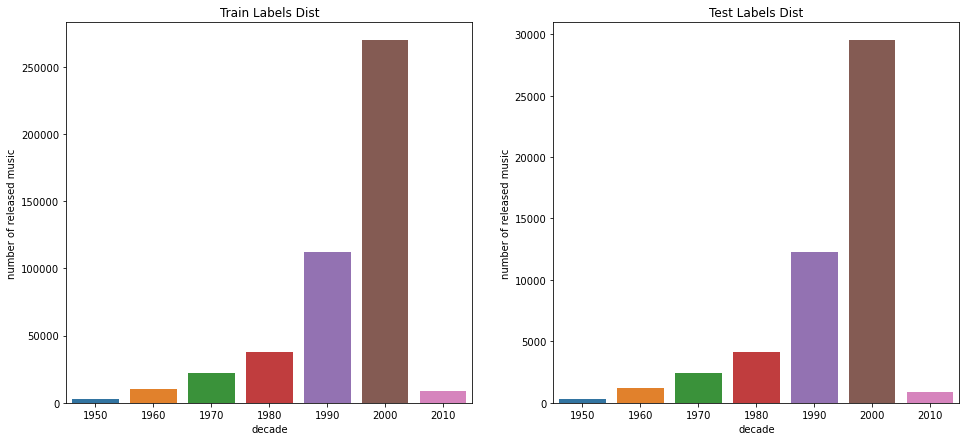

In [122]:
from sklearn.utils import shuffle
data = pd.read_csv('year_prediction.csv')
data['label'] = data.label.apply(lambda year : year-(year%10))
data = data[data['label']>1940]
data = data.sample(frac=1)
data.reset_index(inplace=True, drop=True)


train = data.iloc[:463810]
test = data.iloc[463810:]

#train
X_train = train.drop('label', axis=1)
y_train = train['label']

# Test set
X_test = test.drop('label', axis=1)
y_test = test['label']

f,ax=plt.subplots(1,2,figsize=(16,7))
sns.countplot(y_train, ax=ax[0])
sns.countplot(y_test, ax=ax[1])
ax[0].set_title("Train Labels Dist")
ax[1].set_title("Test Labels Dist")
ax[0].set_xlabel('decade')
ax[0].set_ylabel('number of released music')
ax[1].set_xlabel('decade')
ax[1].set_ylabel('number of released music')
plt.show()


#prepare data for classification
#normalize features and Binarize labels

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)

X_train,y_train = shuffle(X_train,y_train)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

In [138]:
def get_network():
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(512, input_shape=(90,), activation="relu"))
    model.add(keras.layers.Dense(512, activation="relu"))
    model.add(keras.layers.Dense(7, activation="softmax"))
    opt = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(loss= "categorical_crossentropy", optimizer= opt, metrics=["accuracy"])
    return model

In [173]:
class EarlyStoppingCallback(keras.callbacks.Callback):
    
    def __init__(self,patience = 0):
        super(EarlyStoppingCallback,self).__init__()
        self.patience = patience
        
    def on_train_begin(self, logs=None):
        self.best = np.inf
        self.wait = 0
        self.stopped_epoch = 0
        
    def on_epoch_end(self,epoch,logs=None):
        current_loss = logs.get('val_loss')
        if np.less(current_loss,self.best):
            self.best = current_loss
            self.wait = 0
            self.best_weights = self.model.get_weights()
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                self.model.set_weights(self.best_weights)
    
    def on_train_end(self,logs=None):
        if self.stopped_epoch > 0:
            print('epoch: %d early stopping'% self.stopped_epoch)
                
        

In [174]:
model = get_network()
model = keras.wrappers.scikit_learn.KerasRegressor(build_fn=get_network, epochs=50, batch_size=32)

EarlyStoppingCallback = EarlyStoppingCallback(patience=5)
model.fit(X_train,y_train,validation_split = 0.22,callbacks=[EarlyStoppingCallback])



Epoch 1/50
11306/11306 [==============================] - 14s 1ms/step - loss: 363953.2941 - mae: 324.3379 - val_loss: 854.2189 - val_mae: 18.9617
Epoch 2/50
11306/11306 [==============================] - 12s 1ms/step - loss: 486.4752 - mae: 13.4547 - val_loss: 208.7411 - val_mae: 10.4891
Epoch 3/50
11306/11306 [==============================] - 12s 1ms/step - loss: 230.1430 - mae: 10.6162 - val_loss: 190.0526 - val_mae: 9.7954
Epoch 4/50
11306/11306 [==============================] - 13s 1ms/step - loss: 218.0739 - mae: 9.9961 - val_loss: 196.4312 - val_mae: 10.4401
Epoch 5/50
11306/11306 [==============================] - 12s 1ms/step - loss: 217.3937 - mae: 10.0859 - val_loss: 374.6031 - val_mae: 13.2290
Epoch 6/50
11306/11306 [==============================] - 12s 1ms/step - loss: 197.2941 - mae: 9.8068 - val_loss: 137.5673 - val_mae: 8.2280
Epoch 7/50
11306/11306 [==============================] - 12s 1ms/step - loss: 177.9494 - mae: 9.2060 - val_loss: 161.4607 - val_mae: 9.8256
E

In [142]:
preds = model.predict(X_test)

C:\Users\Lenovo\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [149]:
label_single = [i.argmax() for i in y_test]

In [152]:
def accuracy(y_true, y_pred):
    accuracy = np.sum(y_true == y_pred) / len(y_true)
    return accuracy

In [153]:
#accuracy on test dataset
accuracy(label_single, preds)

0.6604145711299134

<AxesSubplot:>

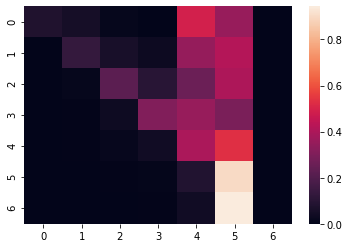

In [151]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(label_single, preds)
cm_df= pd.DataFrame(cm)
cm_df = cm_df.apply(lambda x: x/sum(x), axis ='columns')
sns.heatmap(cm_df)

# classification /71 class

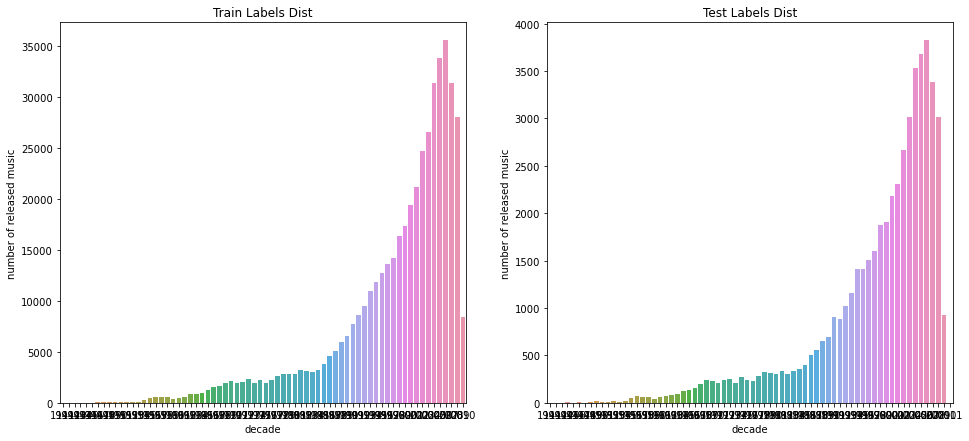

In [111]:
from sklearn.utils import shuffle
data = pd.read_csv('year_prediction.csv')

data = data[data['label']>1940]
data = data.sample(frac=1)
data.reset_index(inplace=True, drop=True)


train = data.iloc[:463810]
test = data.iloc[463810:]

#train
X_train = train.drop('label', axis=1)
y_train = train['label']

# Test set
X_test = test.drop('label', axis=1)
y_test = test['label']

f,ax=plt.subplots(1,2,figsize=(16,7))
sns.countplot(y_train, ax=ax[0])
sns.countplot(y_test, ax=ax[1])
ax[0].set_title("Train Labels Dist")
ax[1].set_title("Test Labels Dist")
ax[0].set_xlabel('decade')
ax[0].set_ylabel('number of released music')
ax[1].set_xlabel('decade')
ax[1].set_ylabel('number of released music')
plt.show()


#prepare data for classification
#normalize features and Binarize labels

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)

X_train,y_train = shuffle(X_train,y_train)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

In [116]:
def get_network():
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(32, input_shape=(90,), activation="relu"))
    model.add(keras.layers.Dense(32, activation="relu"))
    model.add(keras.layers.Dense(70, activation="softmax"))
    opt = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(loss= "categorical_crossentropy", optimizer= opt, metrics=["accuracy"])
    return model

In [117]:
class EarlyStoppingCallback(keras.callbacks.Callback):
    
    def __init__(self,patience = 0):
        super(EarlyStoppingCallback,self).__init__()
        self.patience = patience
        
    def on_train_begin(self, logs=None):
        self.best = np.inf
        self.wait = 0
        self.stopped_epoch = 0
        
    def on_epoch_end(self,epoch,logs=None):
        current_loss = logs.get('val_loss')
        if np.less(current_loss,self.best):
            self.best = current_loss
            self.wait = 0
            self.best_weights = self.model.get_weights()
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                self.model.set_weights(self.best_weights)
    
    def on_train_end(self,logs=None):
        if self.stopped_epoch > 0:
            print('epoch: %d early stopping'% self.stopped_epoch)
                
        

In [118]:
model = get_network()
model = keras.wrappers.scikit_learn.KerasClassifier(build_fn=get_network, epochs=50, batch_size=32)

EarlyStoppingCallback = EarlyStoppingCallback(patience=5)
model.fit(X_train,y_train,validation_split = 0.22,callbacks=[EarlyStoppingCallback])


Epoch 1/50
11306/11306 [==============================] - 10s 847us/step - loss: 3.2751 - accuracy: 0.0787 - val_loss: 3.1263 - val_accuracy: 0.0871
Epoch 2/50
11306/11306 [==============================] - 10s 918us/step - loss: 3.1111 - accuracy: 0.0909 - val_loss: 3.1018 - val_accuracy: 0.0916
Epoch 3/50
11306/11306 [==============================] - 11s 950us/step - loss: 3.0903 - accuracy: 0.0938 - val_loss: 3.0910 - val_accuracy: 0.0930
Epoch 4/50
11306/11306 [==============================] - 11s 988us/step - loss: 3.0816 - accuracy: 0.0945 - val_loss: 3.0907 - val_accuracy: 0.0934
Epoch 5/50
11306/11306 [==============================] - 11s 1ms/step - loss: 3.0770 - accuracy: 0.0960 - val_loss: 3.0829 - val_accuracy: 0.0956
Epoch 6/50
11306/11306 [==============================] - 12s 1ms/step - loss: 3.0720 - accuracy: 0.0951 - val_loss: 3.0797 - val_accuracy: 0.0962
Epoch 7/50
11306/11306 [==============================] - 11s 932us/step - loss: 3.0675 - accuracy: 0.0967 - v